![Image](../resources/header.png)
<h1 align="center">Decoding data from the Allen Brain Observatory</h1> 
<h3 align="center">TReND CaMinA 2024</h3>

<div style="background: #ADD8E6; border-radius: 3px; padding: 10px;">

In this notebook we're going to continue with the idea of using the neural responses to decode information about the corresponding stimuli, but introducing tools and concepts from machine learning that will simplify this process and let us generalize to decoding an entire population of cells.
</div>

### Brain Observatory Setup

In [1]:
# standard data access code
import os
import platform
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

# Set file location based on platform. 
platstring = platform.platform()
if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/TReND2024/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on Code Ocean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/TReND2024/"

manifest_file = os.path.join(data_root,'allen-brain-observatory/visual-coding-2p/manifest.json')
boc = BrainObservatoryCache(manifest_file=manifest_file)

In [2]:
# imports for this notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

## Load dataset and mean responses

We've chosen a pair of example cells from the same session to work with here. Start by finding the drifting gratings session that contains these cells, and loading the corresponding data.

In [3]:
# chosen example cells
cell1_id = 517417584
cell2_id = 517417136

session = boc.get_ophys_experiments(cell_specimen_ids=[cell1_id], stimuli=['drifting_gratings'])[0]
session_id = session['id']

data_set = boc.get_ophys_experiment_data(session_id)
cells_index = data_set.get_cell_specimen_indices([cell1_id, cell2_id])
session

{'id': 502793808,
 'imaging_depth': 175,
 'targeted_structure': 'VISl',
 'cre_line': 'Cux2-CreERT2',
 'reporter_line': 'Ai93(TITL-GCaMP6f)',
 'acquisition_age_days': 117,
 'experiment_container_id': 511510640,
 'session_type': 'three_session_A',
 'donor_name': '222426',
 'specimen_name': 'Cux2-CreERT2;Camk2a-tTA;Ai93-222426',
 'fail_eye_tracking': True}

Next find the code you used yesterday to calculate trial-average responses for all cells in an experiment and apply that here. Drop the blank sweeps from the stim table first, we won't be using those in this analysis.

In [4]:
timestamps, dff = data_set.get_dff_traces()
stim_table = data_set.get_stimulus_table("drifting_gratings")
stim_table = stim_table[stim_table['blank_sweep']==False]

all_cells_index = range(dff.shape[0])
mean_sweep_response = pd.DataFrame(index=stim_table.index, columns=all_cells_index, dtype=float)
# you'll need to loop over trials, but try not to loop over cells!

for trial in stim_table.index:
    mean_sweep_response.loc[trial, :] = dff[
        :, stim_table.loc[trial, "start"] : stim_table.loc[trial, "end"]
    ].mean(axis=1)


One additional preparation step here is that we want to rescale (normalize) the responses by cell, subtracting the mean and dividing by the standard deviation so that all of our features have zero mean and unit variance.

Define a `norm_responses` array to store the normalized mean responses, and then also select the subset of sweeps (from the stimulus table) and responses with temporal frequency equal to 2 (we'll come back to other frequencies later.)

In [5]:
# Normalize the responses
# Tip: this is easier to do with a numpy array

norm_responses = mean_sweep_response.values
norm_responses = (norm_responses 
    - norm_responses.mean(axis=1, keepdims=True)) / norm_responses.std(axis=1, keepdims=True)

In [6]:
# Use the information in the stimulus table to select a subset of responses at a particular temporal frequency

selected_sweeps = (stim_table['temporal_frequency'] == 2.0)
selected_responses = norm_responses[selected_sweeps, :]

## Machine learning with scikit-learn

We are going to use some basic machine learning to solve a *classification* problem based on this data: given the responses of a set of cells on a given trial, can we predict the stimulus orientation of that trial? 

We'll use the package scikit-learn (sklearn), which is a popular and powerful machine learning package in Python. One strength of this package is a simple interface (pattern of use) for a variety of different machine learning tools, or *estimators*. It follows an *object-oriented* approach - each estimator is a Python class which must first be initialized, then passed data to fit and make predictions from.

We typically represent the data feature matrix by a variable `X` (capital to indicate a 2D matrix, with each column a distinct feature and each row a sample) and the target data by a variable `y` (lowercase to indicate a 1D vector). Once we have initialized a specific estimator (like `model = LogisticRegression()`), the key methods always take the same form: we fit the model using `model.fit(X, y)` and make predictions using `y_pred = model.predict(X)`.

This pattern can be used for different types of problems: *classification* when the target is categorical, *regression* when the target is continuous, or even *unsupervised* problems like dimensionality reduction or clustering where there is no target data to train on. Chains of estimators can also be combined into *pipelines* that can be used just as easily as any other estimator.


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<h1>Part 1: Making and interpreting predictions from 2 cells</h1>

</div>

### Binary classification


We'll start with a *binary classification* of the drifting grating stimuli, predicting whether the orientation matches a single target orientation, based on mean responses from just a single cell.

In [7]:
# First define X and y

# Create a binary indicator for our selected orientation
target_orientation = 45

y = (stim_table.loc[selected_sweeps, 'orientation'] == target_orientation).astype(int)

# and select the response of the first cell, making sure it has shape (n_trials, 1)

X = selected_responses[:, [cells_index[0]]]
X.shape

(119, 1)

In [8]:
# Create an instance of the Logistic Regression model
# we've filled in some parameters that are needed for this particular problem
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(class_weight="balanced", C=1e6)

# Fit the model

model.fit(X, y)

# Predict the target variable 

y_pred = model.predict(X)

# Calculate the accuracy of the model (on what percent of trials does the prediction match the target)

accuracy = (y == y_pred).mean()
print(accuracy)

0.773109243697479


### Visualizing classifier predictions
The classifier we chose has the advantage of a fairly simple mathematical formulation, allowing us to interpret how it makes its predictions. It is a *linear* classifier, meaning the classifier predicts "true" if $C + k \cdot x > 0$ and "false" otherwise, defining a dividing line to split the input space into true and false samples. We can plot this line using properties of the fitted classifier.

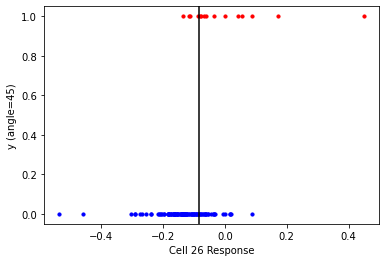

In [9]:
# first create a scatter plot of the responses and target variable (y vs X)
# with 'true' responses in red and 'false' in blue

cell1_responses = selected_responses[:, cells_index[0]]
target_trials = y.astype(bool)
plt.scatter(cell1_responses[target_trials], y[target_trials], s=10, color='red', label=f"angle={target_orientation}")
plt.scatter(cell1_responses[~target_trials], y[~target_trials], s=10, color='blue', label="other angles")
plt.xlabel(f'Cell {cells_index[0]} Response')
plt.ylabel(f"y (angle={target_orientation})")

# pull the coefficient k and intercept C out of the classifier
k = model.coef_[0][0]
C = model.intercept_

# calculate the dividing line and plot with axvline

x_cutoff = -C / k
plt.axvline(x_cutoff, color='black')
plt.show()


### Logistic regression and probabilities
The parameters of this line are determined by optimizing a probabilistic model of the data, $\mathrm{Pr}(y) = f(C + k_0 \cdot x_0 + k_1 \cdot x_1 + \dots)$, where $f$ is the *logistic function* shown in the plot below, $f(x) = \frac{1}{1-e^{-x}}$:

![logistic curve](https://upload.wikimedia.org/wikipedia/commons/8/88/Logistic-curve.svg)

We can check these probabilities for any point in our input space using the function `model.predict_proba(X)`. We can then add probabilities to our two-cell response plot also.

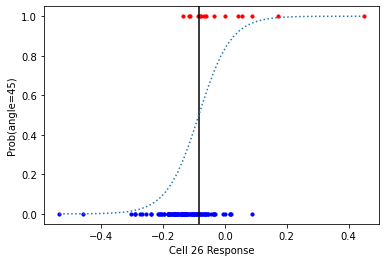

In [10]:
# create the plot again...

plt.scatter(cell1_responses[target_trials], y[target_trials], s=10, color='red', label=f"angle={target_orientation}")
plt.scatter(cell1_responses[~target_trials], y[~target_trials], s=10, color='blue', label="other angles")
plt.xlabel(f'Cell {cells_index[0]} Response')
plt.ylabel(f"Prob(angle={target_orientation})")
plt.axvline(x_cutoff, color='black')

# define a range of x-values to calculate probabilities for

xx = np.linspace(cell1_responses.min(), cell1_responses.max(), 50)

# predict_proba returns two columns, one for each class - we want the probability of class 1 (angle=45)
# Tip: [:,None] reshapes the array to have shape (n, 1) instead of (n,)
probs = model.predict_proba(xx[:,None])[:, 1]

# plot the probabilities
plt.plot(xx, probs, ':')
plt.show()

### Classification in 2 dimensions

We can add a second cell and fit as before, then visualize this case also, in two dimensions.

In [11]:
# redefine X to include both cells

X = selected_responses[:, cells_index]

# Fit the model

model.fit(X, y)

# find the accuracy - try using model.score instead of calculating it manually

model.score(X, y)

0.8487394957983193

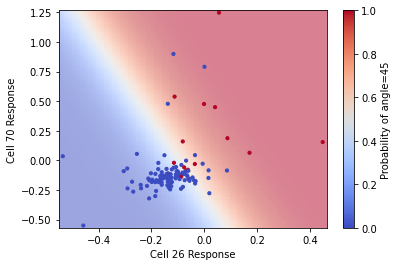

In [12]:
# There is a built-in function to visualize the classifier boundary and probabilities
from sklearn.inspection import DecisionBoundaryDisplay

# we've filled in some suggested parameters here, but feel free to change them
DecisionBoundaryDisplay.from_estimator(
    model,
    X,
    plot_method="pcolormesh",
    response_method="predict_proba",
    ax=plt.gca(),
    cmap="coolwarm",
    vmin=0,
    vmax=1,
    alpha=0.5,
    shading="auto",
    eps=0.01,
)

# add the data points as before

cell1_responses = selected_responses[:, cells_index[0]]
cell2_responses = selected_responses[:, cells_index[1]]
plt.scatter(cell1_responses, cell2_responses, s=10, c=y, cmap="coolwarm")
plt.xlabel(f"Cell {cells_index[0]} Response")
plt.ylabel(f"Cell {cells_index[1]} Response")

# add a colorbar showing the scale
plt.colorbar(label=f"Probability of angle={target_orientation}")
plt.show()

### Extra: Detailed walkthrough of 2D visualization methods

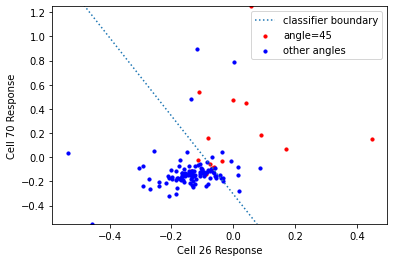

In [13]:
# first create a scatter plot of the two cells' responses colored by y
# with 'true' responses in red and 'false' in blue
cell1_responses = selected_responses[:, cells_index[0]]
cell2_responses = selected_responses[:, cells_index[1]]
target_trials = y.astype(bool)
plt.scatter(cell1_responses[target_trials], cell2_responses[target_trials], s=10, color='red', label=f"angle={target_orientation}")
plt.scatter(cell1_responses[~target_trials], cell2_responses[~target_trials], s=10, color='blue', label="other angles")
plt.xlabel(f'Cell {cells_index[0]} Response')
plt.ylabel(f'Cell {cells_index[1]} Response')


# pull the coefficient parameters k out of the classifier
k = model.coef_[0]
C = model.intercept_

# pick evenly spaced x-values to plot the classifier boundary line
n = 10
x_line = np.linspace(cell1_responses.min(), cell1_responses.max(), n)

# calculate the y-values of the classifier boundary line using the equation above
y_line = (-C - k[0] * x_line) / k[1]
plt.plot(x_line, y_line, ':', label="classifier boundary")

# adjust the plot bounds with plt.ylim
plt.ylim(cell2_responses.min(), cell2_responses.max())

plt.legend()
plt.show()

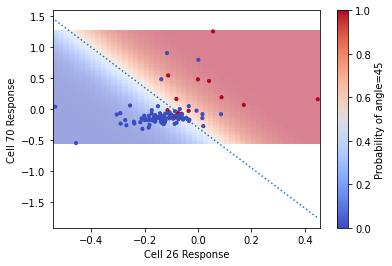

In [14]:
# the coolwarm colormap is nice for probabilities, mapping values between 0 and 1 to colors from blue to red
cmap = plt.cm.coolwarm
# we can use this colormap to color our response scatterplot by the binary targets y

# pass evenly spaced x and y coordinates to np.meshgrid to create a grid
n = 50
xx = np.linspace(cell1_responses.min(), cell1_responses.max(), n)
yy = np.linspace(cell2_responses.min(), cell2_responses.max(), n)
xgrid, ygrid = np.meshgrid(xx, yy)

# flatten and stack these lists to create a X matrix to pass to model.predict_proba
Xgrid = np.vstack([xgrid.flatten(), ygrid.flatten()]).T
probs = model.predict_proba(Xgrid)[:, 1]

# reshape the probabilities to fit the shape of the grid
probs_grid = probs.reshape(n, n)
plt.pcolormesh(xgrid, ygrid, probs_grid, cmap=cmap, alpha=0.5, shading='auto')

# finally, copy the code for our response scatter plot to overlay it here
plt.scatter(cell1_responses, cell2_responses, s=10, c=y, cmap='coolwarm')
plt.plot(x_line, y_line, ':', label="classifier boundary")
plt.xlabel(f'Cell {cells_index[0]} Response')
plt.ylabel(f'Cell {cells_index[1]} Response')

# and add a colorbar for the probabilities
plt.colorbar(label=f'Probability of angle={target_orientation}')
plt.show()


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<h1>Part 2: Population decoding</h1>

</div>

### Predicting all orientations

We can also use the `LogisticRegression` classifier to predict which of the 8 orientations a response comes from. This involves a mathematical model for the probability of each class/orientation, which are then compared for a final prediction. Scikit-learn makes this very easy, adapting the model to do this in the background if we simply pass a *categorical* rather than *binary* target variable `y`.

In [15]:
# redefine y to include all orientations, fit, and find the model accuracy score
# Hint: you can actually use the column directly from the dataframe (or convert to an array)

X = selected_responses[:, cells_index]
y = stim_table.loc[selected_sweeps, 'orientation']
model.fit(X, y)
model.score(X, y)

0.3445378151260504

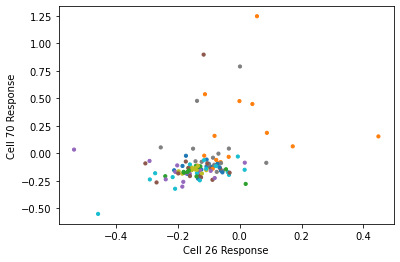

In [16]:
# Here's a way to quickly plot the responses labeled by orientation,
# to assess whether this poor performance makes sense
plt.scatter(*X.T, s=10, c=y, cmap='tab10')
plt.xlabel(f'Cell {cells_index[0]} Response')
plt.ylabel(f'Cell {cells_index[1]} Response')
plt.show()

This is not very good, as expected - two cells can only tell us so much. However, sklearn makes it very easy to train on all recorded cells in the session together!

In [17]:
# We need to adjust the model here for this more complex setting
model = LogisticRegression(max_iter=10000)

# redefine X to include all cells, fit, and find the model accuracy score

X = selected_responses
y = stim_table.loc[selected_sweeps, 'orientation']

model.fit(X, y)
model.score(X, y)

1.0

Discuss: Does anything seem odd to you about this result? Let's discuss why this may not be as perfect as it seems.

### Splitting training and test data

Our ultimate goal is a model that captures **true** patterns in the data, but what does "true" mean here? One way of resolving this scientifically would be to experiment: generate more data from the same cells and see if the same patterns are present (if the estimator can predict the stimuli well on the new data). Practically, we can't usually repeat experiments like this, but we can instead hide some of the existing data during the *fit* step and use it only to predict and evaluate. We call the fit data the training dataset, and the hidden data the test dataset.

Sklearn has a method to shuffle the data (across trials) and make this split randomly `train_test_split`.

Discuss: Why might shuffling be important here?

In [18]:
from sklearn.model_selection import train_test_split

# this introduces randomness, so set the random 'seed' for reproducibility
np.random.seed(5)
# stratify=y ensures that the train and test sets have the same proportion of each class
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)


In [19]:
# Fit the model on the training data, and score (predict) on the test data

model.fit(X_train, y_train)
model.score(X_test, y_test)


0.8

### Viewing the confusion matrix

Let's also visualize a confusion matrix of the pattern of errors. Sklearn has a built-in method for this - try out the function `sklearn.metrics.ConfusionMatrixDisplay.from_estimator()`

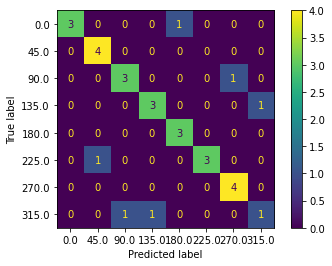

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay

cm_display = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

### Fitting with all temporal frequencies

It's hard to tell if there is a pattern in the above confusion matrix because there are not many trials to plot in our test set. Let's try adding back in the other trials.

In [21]:
# define X and y, fit and score the model

X = norm_responses
y = stim_table['orientation']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)

model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7533333333333333

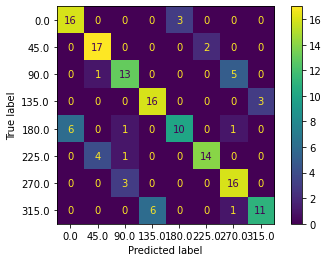

In [22]:
# plot a confusion matrix

cm_display = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test , normalize=None)

In this case, decoding performance is similar when we include all temporal frequencies. This may not always be true: the effect of temporal frequency can be very different in different experiments if different cell types are sampled (by Cre or depth targeting, or just different fields of view).

One advantage of the full dataset, though, is that with more samples we can begin to see a clear pattern to the errors in the confusion matrix plot.

Discuss: what do you think this pattern means?

# Exercises:

### Exercise: Train a classifier on natural image responses

In [23]:
# find the dataset and stim table for natural scenes for the same cells as above

exps = boc.get_ophys_experiments(cell_specimen_ids=[cell1_id], stimuli=['natural_scenes'])
session_id = exps[0]['id']
data_set_ns = boc.get_ophys_experiment_data(session_id)

stim_table_ns = data_set_ns.get_stimulus_table("natural_scenes")
stim_table_ns.head()

,frame,start,end
0,2,16098,16105
1,107,16106,16113
2,54,16114,16121
3,53,16121,16128
4,41,16129,16136


In [24]:
# how many times is each stimulus presented?

stim_table_ns["frame"].value_counts()

frame
2      50
108    50
3      50
96     50
85     50
       ..
11     50
22     50
45     50
94     50
44     50
Name: count, Length: 119, dtype: int64

In [25]:
# choose a handful of images and subset the stim table to just the relevant trials
images = [13, 15, 18]

sweeps = stim_table_ns[stim_table_ns["frame"].isin(images)]

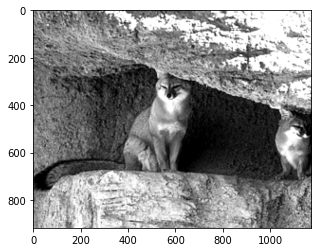

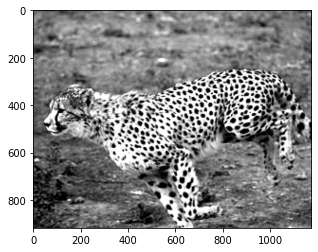

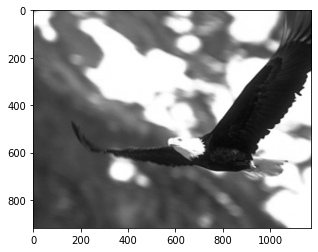

In [28]:
# for fun, let's plot the images we've selected
natural_scene_template = data_set_ns.get_stimulus_template('natural_scenes')
for i in images:
    plt.imshow(natural_scene_template[i,:,:], cmap='gray')
    plt.show()

In [ ]:
# make your code from above into a function to calculate the normalized mean sweep response
def get_mean_sweep_response(dff, stim_table):

    all_cells_index = range(dff.shape[0])
    mean_sweep_response = pd.DataFrame(index=stim_table.index, columns=all_cells_index)

    for trial in stim_table.index:
        mean_sweep_response.loc[trial, :] = dff[
            :, stim_table.loc[trial, "start"] : stim_table.loc[trial, "end"]
        ].mean(axis=1)
    # Normalize
    X = mean_sweep_response.values.astype(float)
    X = (X - X.mean(axis=1, keepdims=True)) / X.std(axis=1, keepdims=True)
    return X

# then run it on the natural scenes data

timestamps, dff = data_set_ns.get_dff_traces()
response = get_mean_sweep_response(dff, sweeps)

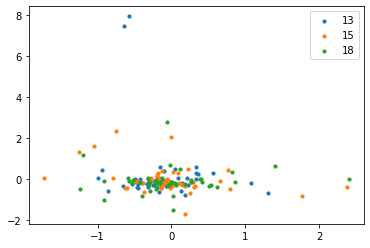

In [ ]:
# define X and y for responses of the pair of cells,
# then plot the responses colored by the image frame

# Tip: the cell indices may be different in this new session/dataset

cells_index = data_set_ns.get_cell_specimen_indices([cell1_id, cell2_id])
X = response[:, cells_index]
y = sweeps["frame"]

for value in y.unique():
    subset = y == value
    plt.scatter(X[subset, 0], X[subset, 1], s=10, label=value)

# don't forget to add a legend (and labels)
plt.legend()
plt.show()


In [ ]:
# define X and y for the population of cells, split train and test data,
# then fit and score a logistic regression classifier and plot the confusion matrix
model = LogisticRegression(max_iter=10000)

X = response
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)

model.fit(X_train, y_train)
model.score(X_test, y_test)

0.39473684210526316

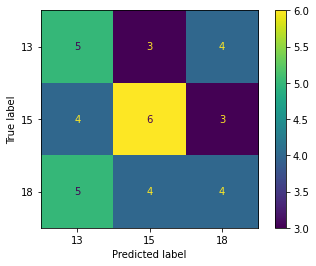

In [ ]:
cm_display = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test , normalize=None)

### Exercise: training with "class imbalance"

You might be wondering why we set the option `LogisticRegression(class_weight='balanced')`. Try rerunning the binary classification portions without this option and see if you can make sense of how the predictions and classifier boundary change. Hint: it's related to the fact that there are many more "false" trials than "true" trials. 

While the accuracy score will likely improve, you should be able to visually identify why we might not want this result. There are other metrics in the `sklearn.metrics` module that may better capture our intuitive idea of a "good model" here - try `f1_score` for instance.

### Exercise: Scoring with cross validation

*Cross-validation* is an approach to test model performance on the entire dataset, while avoiding the problem of training and testing on the same data. Instead, the data is split multiple times (with the model retrained each time), so that each sample is part of the test set a single time.

![diagram of cross-validation](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/K-fold_cross_validation_EN.svg/640px-K-fold_cross_validation_EN.svg.png)

Scikit-learn contains a function that makes this ease, `cross_val_score` - try using this to compare performance on all temporal frequencies vs the single one we selected. These results should now be more reliable across multiple runs than our previous comparison!

In [ ]:
from sklearn.model_selection import cross_val_score
model = LogisticRegression(max_iter=10000)

# run cross_val_score on all sweeps, predicting all orientations

X = norm_responses
y = stim_table['orientation']
cross_val_score(model, X, y, cv=5).mean()

0.7643417366946779

In [ ]:
# run cross_val_score on selected sweeps (single TF)

X = norm_responses[selected_sweeps]
y = stim_table.loc[selected_sweeps, 'orientation']
cross_val_score(model, X, y, cv=5).mean()

0.7293478260869566

### Exercise: Classifier for both TF & orientation

We've seen that decoding can do fairly well with all the data, not knowing about the temporal frequency at all. Is it possible we could increase performance even more by training on both orientation and temporal frequency labels together? A few classifiers in sklearn can function in the *multi-output* context where we pass a 2D matrix of target data instead of a vector. We'll test out one of these, the random forest classifier.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define the target variable and the feature matrix, and run the train_test_split function

X = norm_responses
Y = stim_table[['temporal_frequency', 'orientation']]
X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.25)

# Create an instance of the Random Forest model, fit the model, and predict the target variable

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [ ]:
# we can't use model.score in this context, so instead generate a prediction of the target variables,
# and evaluate accuracy separately each one, using the accuracy_score function
from sklearn.metrics import accuracy_score

print("temporal frequency accuracy: ", accuracy_score(y_test.values[:,0], y_pred[:,0]))
print("orientation accuracy: ", accuracy_score(y_test.values[:,1], y_pred[:,1]))

temporal frequency accuracy:  0.56
orientation accuracy:  0.78


This is similar to before, but is it actually better? How much does performance vary run to run? As implied in the name, the random forest classifier has an element of randomness in its performance.

We should also compare to the same classifier's performance on orientation data only.

In [ ]:
# Repeat the above process with orientation data only in Y

X = norm_responses
Y = stim_table['orientation']
X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.25)

model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7666666666666667